In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
dataset_path = '/content/drive/MyDrive/brain_tumor'

# Set the paths to train and test folders
train_dir = os.path.join(dataset_path, 'train_set')
test_dir = os.path.join(dataset_path, 'test_set')


In [3]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 219 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [4]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [5]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [6]:
model.fit(train_generator,
          steps_per_epoch=train_generator.samples,
          epochs=10,
          validation_data=test_generator,
          validation_steps=test_generator.samples)

Epoch 1/10
 11/219 [>.............................] - ETA: 8:39 - loss: 0.5369 - accuracy: 0.7443

219/219 [==============================] - 48s 181ms/step - loss: 0.5369 - accuracy: 0.7443 - val_loss: 0.7144 - val_accuracy: 0.7297


In [14]:
model.save("braintumor.h5")

In [8]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [9]:
model=load_model('chat.h5')

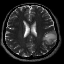

In [10]:
img=image.load_img(r"/content/drive/MyDrive/brain_tumor/test_set/no/N22.JPG",target_size=(64,64))
img

In [11]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values (similar to what we did during training)
    return img_array
x = preprocess_image("/content/drive/MyDrive/no/1 no.jpeg")

pred=model.predict(x)
print(pred)

1/1 [==============================] - 0s 153ms/step
[[0.16303137]]


In [12]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('chat.h5')

# Now, you can use the loaded model to predict on new data
# For example, if you have a new image that you want to test, you can preprocess it and make predictions as follows:

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values (similar to what we did during training)
    return img_array

new_image_path = '/content/drive/MyDrive/no/2 no.jpeg'
new_image = preprocess_image(new_image_path)

# Use the loaded model to make predictions on the new image
prediction = loaded_model.predict(new_image)

# The 'prediction' variable now contains the model's prediction, which is a value close to 0 for 'no tumor' and close to 1 for 'tumor'
# You can interpret the prediction based on the threshold (e.g., if prediction >= 0.5, it's predicted as 'tumor')
if prediction >0.5:
    print("The model predicts that the image has a brain tumor.")
else:
    print("The model predicts that the image does not have a brain tumor.")
print(prediction)

1/1 [==============================] - 0s 96ms/step
The model predicts that the image does not have a brain tumor.
[[0.19921926]]


In [13]:
import os
import numpy as np
import tensorflow as tf
from flask import Flask, request, render_template, redirect, url_for
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads'
app.config['ALLOWED_EXTENSIONS'] = {'jpg', 'jpeg', 'png'}

# Load the trained model
model = load_model('chat.h5')

# Helper function to check if the file has an allowed extension
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

# Route to handle the home page
@app.route('/')
def index():
    return render_template('index.html')

# Route to handle the prediction
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        if 'file' not in request.files:
            return redirect(request.url)

        file = request.files['file']

        if file.filename == '':
            return redirect(request.url)

        if file and allowed_file(file.filename):
            # Save the uploaded file to the 'uploads' folder
            filename = file.filename
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)

            # Preprocess the image
            img = load_img(file_path, target_size=(150, 150))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            # Use the model to make predictions
            prediction = model.predict(img_array)

            # Interpret the prediction
            if prediction >= 0.5:
                result = 'Tumor detected'
            else:
                result = 'No tumor detected'

            return render_template('result.html', filename=filename, result=result)
        else:
            return render_template('error.html', error='Invalid file format. Please upload an image (jpg, jpeg, or png).')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
